# Vision-Language Model

* 4bit quantised idefics-80b VLM
* 4bit quantised idefics-80b VLM with instruction-tuning

*use `idefics_colab` conda env*

In [72]:
import torch
from PIL import Image
from transformers import IdeficsForVisionText2Text, AutoProcessor, BitsAndBytesConfig
import torchvision.transforms as transforms
from sidemethods import load_richardson_data
from tqdm import tqdm
import itertools
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import seaborn as sns


_, richardson_data, richardson_normed = load_richardson_data()
action_words = richardson_normed.keys()

In [19]:
gpu = 1 # "all" or INT: 0,1,2,3
quantised = True

model_name = "idefics/idefics-80b"

In [3]:
# Check available gpu (gpustat -i)
if gpu == "all":
    device_map = "auto"
elif isinstance(gpu, int):
    device_map = {"" : gpu}


# checkpoint = "HuggingFaceM4/tiny-random-idefics"
local_path = "/mounts/data/corp/huggingface/"
checkpoint = local_path+model_name

# Here we skip some special modules that can't be quantized properly
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    llm_int8_skip_modules=["lm_head", "embed_tokens"],
)

processor = AutoProcessor.from_pretrained(checkpoint, use_auth_token=True)
# Simply take-off the quantization_config arg if you want to load the original model
if quantised:
    model = IdeficsForVisionText2Text.from_pretrained(checkpoint,quantization_config=bnb_config, device_map=device_map) 
else:
    model = IdeficsForVisionText2Text.from_pretrained(checkpoint, device_map=device_map) 


/mounts/Users/cisintern/pwicke/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mounts/work/pwicke/miniconda3/envs/idefics_colab/lib/python3.10/site-packages/transformers/models/auto/processing_auto.py:206: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/mounts/Users/cisintern/pwicke/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Loading checkpoint shards: 100%|██████████| 17/17 [04:57<00:00, 17.50s/it]


1

In [33]:
def check_inference(model, processor, prompts, max_new_tokens=50):
    tokenizer = processor.tokenizer
    bad_words = ["<image>", "<fake_token_around_image>"]
    if len(bad_words) > 0:
        bad_words_ids = tokenizer(bad_words, add_special_tokens=False).input_ids

    eos_token = "</s>"
    eos_token_id = tokenizer.convert_tokens_to_ids(eos_token)

    if gpu == "all":
        inputs = processor(prompts, return_tensors="pt")
    else:
        inputs = processor(prompts, return_tensors="pt").to(device_map[""])
        
    generated_ids = model.generate(**inputs, eos_token_id=[eos_token_id], bad_words_ids=bad_words_ids, max_new_tokens=max_new_tokens, early_stopping=True)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

## Testing Prompts for Experiment

In [34]:
images = []
for i in range(1,5):
    img_path = "../../data/direction0"+str(i)+".png"
    images.append(Image.open(img_path).convert("RGB"))

prompts = [
    # "Instruction: provide an answer to the question. Use the image to answer.\n",
    "Image A:",
    images[0],
    "Image B:",
    images[1],
    "Image C:",
    images[2],
    "Image D:",
    images[3],
    "Question: Which one of the images (A-D) describes the event 'arrow down' best? Answer: Image "
]
print(check_inference(model, processor, prompts, max_new_tokens=2))


/mounts/work/pwicke/miniconda3/envs/idefics_colab/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Image A: Image B: Image C: Image D: Question: Which one of the images (A-D) describes the event 'arrow down' best? Answer: Image A



In [63]:
images = []
for i in range(1,5):
    img_path = "../../data/direction0"+str(i)+".png"
    images.append(Image.open(img_path).convert("RGB"))

prompts = [
    # "Instruction: provide an answer to the question. Use the image to answer.\n",
    "Image A:",
    images[0],
    "Image B:",
    images[1],
    "Image C:",
    images[2],
    "Image D:",
    images[3],
    "Question: Give a one sentence description for each image. The description should focus on the differences. Answer:"
]
check_inference(model, processor, prompts, max_new_tokens=60)


'Image A: Image B: Image C: Image D: Question: Give a one sentence description for each image. The description should focus on the differences. Answer:\n\nImage A: The object is moving to the right.\n\nImage B: The object is moving to the left.\n\nImage C: The object is moving up and down.\n\nImage D: The object is moving up and down.\n\nQuestion: What is the difference'

# Prompt Search

# Run experiment

 Initial experiments show that encoding with A, B, C, D was heavily favouring the selection of image A no matter the order or image. This suggests that the letter A has some primary features due to its alphabetical order. This bias can potentially be mitigated by selecting a set of codes that are designed to have minimal suggestion of acronyms or patterns, providing a more neutral set of labels for your image classification task

In [91]:
model_choices = dict()
options = {0:'WJZX', 1:'YGPK', 2:'FQHL', 3:'VMBR'} # up, down, left, right

def find_earliest_string(strings, target_string):
    found_strings = [s for s in strings if s in target_string]
    return min(found_strings, key=target_string.find, default=None)

with open("results/VISUAL_"+model_name.split("/")[1]+"_responses.txt", "w") as f_out:
    for action_word in tqdm(action_words): # action_words:#

        if action_word == 0:
            continue

        for choice_list in list(itertools.permutations(options)):
            targets = [options[x] for x in choice_list]
            
            ### PROMPTS DEFINED HERE
            prompts = [
                        # "Instruction: provide an answer to the question. Use the image to answer.\n",
                        f"Image {options[choice_list[0]]}:",
                        images[choice_list[0]],
                        f"Image {options[choice_list[1]]}:",
                        images[choice_list[1]],
                        f"Image {options[choice_list[2]]}:",
                        images[choice_list[2]],
                        f"Image {options[choice_list[3]]}:",
                        images[choice_list[3]],
                        "Question: Which one of the images describes the event '"+action_word+"' best? Do not provide a number, only give the image code. Answer: Image "
                    ]

            new_token_num = 3
            generated_answer = check_inference(model, processor, prompts, max_new_tokens=new_token_num) 
            print("Full answer:", generated_answer)
            generated_answer = generated_answer[-new_token_num-1:]
            print("Retrieved answer:", generated_answer)
            print("-------")

            counted = False
            if action_word not in model_choices.keys():
                model_choices[action_word] = [0,0,0,0]
        
            finding = find_earliest_string(targets, generated_answer)
            if finding:
                model_choices[action_word][targets.index(finding)]+=1
                counted = True

            if sum(model_choices[action_word]) > 24:
                print("Too many arrows in response.")

            f_out.write(action_word+"\t"+", ".join(targets)+"\t"+generated_answer+"\n")

print(model_choices)
# 30min on llama 70b
# 30min on llama 70b chat
# 5min on llama 13b
# 5min on llama 13b chat

  0%|          | 0/30 [00:00<?, ?it/s]/mounts/work/pwicke/miniconda3/envs/idefics_colab/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:418: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Full answer: Image WJZX: Image YGPK: Image FQHL: Image VMBR: Question: Which one of the images describes the event 'fled' best? Do not provide a number, only give the image code. Answer: Image 1

Retrieved answer: e 1

-------
Full answer: Image WJZX: Image YGPK: Image VMBR: Image FQHL: Question: Which one of the images describes the event 'fled' best? Do not provide a number, only give the image code. Answer: Image FQHL
Retrieved answer: FQHL
-------
Full answer: Image WJZX: Image FQHL: Image YGPK: Image VMBR: Question: Which one of the images describes the event 'fled' best? Do not provide a number, only give the image code. Answer: Image 1

Retrieved answer: e 1

-------
Full answer: Image WJZX: Image FQHL: Image VMBR: Image YGPK: Question: Which one of the images describes the event 'fled' best? Do not provide a number, only give the image code. Answer: Image 1

Retrieved answer: e 1

-------
Full answer: Image WJZX: Image VMBR: Image YGPK: Image FQHL: Question: Which one of the im

  0%|          | 0/30 [00:13<?, ?it/s]


KeyboardInterrupt: 

### Storing Experimental Results

In [66]:
to_store = input("Should the result for "+model_name+" be stored? (y/n):")

if to_store == "y":

    with open("results/VISUAL_"+model_name.split("/")[1]+"_selections.txt", "w") as f_out:
        f_out.write("Action\tUP\tDOWN\tLEFT\tRIGHT\n")
        for k,v in model_choices.items():
            f_out.write(k+"\t"+"\t".join([str(x) for x in v])+"\n")
    

### Loading Experimental Results

In [67]:
model_choices = dict()
with open("results/VISUAL_"+model_name.split("/")[1]+"_selections.txt", "r") as f_in:
    lines = f_in.readlines()

for idx,line in enumerate(lines):
    if idx == 0:
        continue
    parts = line.split("\t")
    parts[-1].replace("\n","")
    model_choices[parts[0]] = [int(x) for x in parts[1:]]

### Cosine similarity (within and out of constructs)

In [71]:
similarity_scores_items = {}
similarity_scores_constructs = {'Horizontal':0, 'Neutral':0, 'Vertical':0, 'Horizon.':0, 'Neutr.':0, 'Vertic.':0}

for idx, key in enumerate(richardson_data):

    # for each item
    vec1 = np.array(richardson_data[key])
    vec2 = np.array(model_choices[key])
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    similarity_scores_items[key] = similarity

print(similarity_scores_items)

count = 0
for i in range(0,len(similarity_scores_items),5): # every 5th item is a different construct 
    current_constr = list(similarity_scores_constructs.keys())[count]
    constr_sum = round((sum(list(similarity_scores_items.values())[i:i+4])/5),4)
    similarity_scores_constructs[current_constr] = constr_sum
    count+=1

print(similarity_scores_constructs)

{'fled': 0.46532853903058913, 'pointed at': 0.8573011355323779, 'pulled': 0.480548029318829, 'pushed': 0.9075225504893383, 'walked': 0.9573819084530235, 'hunted': 0.8893923271387824, 'impacted': 0.8520095460180908, 'perched': 0.6401671291613784, 'showed': 0.9926451136177542, 'smashed': 0.5535234875402624, 'bombed': 0.1541689572136528, 'flew': 0.6684756886783507, 'floated': 0.4853981257600043, 'lifted': 0.4980538676929668, 'sank': 0.3790419271466338, 'argued with': 0.950447669904943, 'gave to': 0.8899172239882989, 'offended': 0.8667986676658971, 'rushed': 0.9580543762676038, 'warned': 0.926958324120481, 'owned': 0.6597448863100398, 'regretted': 0.5705390958814034, 'rested': 0.7779723385196862, 'tempted': 0.8103889652239996, 'wanted': 0.9843071297101258, 'hoped': 0.7548024897207117, 'increased': 0.6148666081255608, 'obeyed': 0.5531236508857958, 'respected': 0.8352499478423725, 'succeeded': 0.6482764495775017}
{'Horizontal': 0.5421, 'Neutral': 0.6748, 'Vertical': 0.3612, 'Horizon.': 0.733

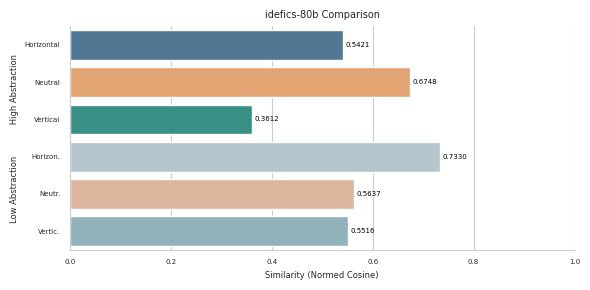

In [73]:
data = similarity_scores_constructs
custom_palette = ['#457b9d', '#f4a261', '#2a9d8f', '#b0c6d1', '#e5b293', '#8ab6c1']

plt.figure(figsize=(6, 3))
sns.set_style("whitegrid")
sns.barplot(x=list(data.values()), y=list(data.keys()), palette=custom_palette)

plt.xlabel('Similarity (Normed Cosine)', fontsize=6)
plt.ylabel('Low Abstraction            High Abstraction', fontsize=6)
plt.title(model_name.split("/")[1]+' Comparison', fontsize=7)

for i, value in enumerate(data.values()):
    plt.text(value + 0.005, i, f'{value:.4f}', va='center', fontsize=5, color='black')

plt.xlim(0, 1)
sns.despine()
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.tight_layout()
plt.savefig("results/VISUAL_"+model_name.split("/")[1]+"_CosSim.png")
plt.show()


In [74]:
# Check if file TEXT_average_similarities.txt exists, else create it
try:
    with open("results/VISUAL_average_similarities.txt", "r") as f_in:
        lines = f_in.readlines()
except FileNotFoundError:
    with open("results/VISUAL_average_similarities.txt", "w") as f_out:
        f_out.write("Model\tAverage Similarity\n")
        f_out.close()


average_sim = sum(similarity_scores_constructs.values())/len(similarity_scores_constructs.values())
print("Average similarity between human choice and model choices is: ", round(average_sim,5))

# Write the average similarity to a text file with the name of the model
# Model name is the first part of the line in the file
# Check if entry for current model already exists, else append

with open("results/VISUAL_average_similarities.txt", "r") as f_in:
    lines = f_in.readlines()

with open("results/VISUAL_average_similarities.txt", "w") as f_out:
    for line in lines:
        if line.startswith(model_name.split("/")[1]):
            line = model_name.split("/")[1]+"\t"+str(average_sim)+"\n"
        f_out.write(line)
        # append average similarity if model not yet in file
    if not any(model_name.split("/")[1] in line for line in lines):
        f_out.write(model_name.split("/")[1]+"\t"+str(average_sim)+"\n")

Average similarity between human choice and model choices is:  0.57107


In [75]:
print("Human % distrib.:", richardson_data)
print("Model distrib.:", model_choices)
model_percentages = {k:[round(100*(x/24),5) for x in entries] for k, entries in model_choices.items()}
print("Model % distrib.:", model_percentages)

Human % distrib.: {'fled': [7.2, 4.2, 80.8, 7.8], 'pointed at': [7.2, 3.6, 0.0, 89.2], 'pulled': [6.0, 5.4, 75.4, 13.2], 'pushed': [7.2, 3.6, 1.2, 88.0], 'walked': [9.0, 3.6, 24.0, 62.9], 'hunted': [9.6, 20.4, 1.8, 68.3], 'impacted': [7.2, 37.1, 3.0, 52.7], 'perched': [12.0, 76.0, 6.6, 5.4], 'showed': [15.0, 9.0, 10.2, 65.9], 'smashed': [3.6, 66.5, 1.2, 28.7], 'bombed': [4.8, 86.8, 1.8, 6.6], 'flew': [37.7, 44.3, 15.0, 3.0], 'floated': [32.9, 56.3, 7.8, 3.0], 'lifted': [87.4, 9.6, 2.4, 0.6], 'sank': [22.2, 71.9, 4.2, 1.8], 'argued with': [11.4, 13.8, 12.6, 62.3], 'gave to': [8.4, 9.6, 1.2, 80.8], 'offended': [9.0, 31.7, 24.6, 34.7], 'rushed': [10.2, 10.8, 23.4, 55.1], 'warned': [10.8, 22.2, 6.0, 61.1], 'owned': [5.4, 55.7, 18.6, 20.4], 'regretted': [19.8, 24.0, 41.3, 15.0], 'rested': [14.4, 36.5, 40.1, 9.0], 'tempted': [16.8, 11.4, 45.5, 26.3], 'wanted': [15.6, 7.8, 15.6, 61.1], 'hoped': [45.5, 15.6, 7.2, 31.7], 'increased': [73.7, 7.2, 9.6, 9.0], 'obeyed': [22.8, 4.2, 64.7, 8.4], 'res

## Spearman R

In [76]:
# Assuming you have two dictionaries: model_percentages and richardson_data
concepts = ["C:◯↑▢", 'D:◯↓▢', 'B:◯←▢ ', 'A:◯→▢']
spearmanr_values = {}

for concept in concepts:
    model_values = [model_percentages[key][concepts.index(concept)] for key in model_percentages]
    richardson_values = [richardson_data[key][concepts.index(concept)] for key in richardson_data]

    spearmanr_result = spearmanr(model_values, richardson_values)
    spearmanr_values[concept] = spearmanr_result.correlation, spearmanr_result.pvalue

In [77]:
# Check if file TEXT_spearmanr.txt exists, else create it

try:
    with open("results/VISUAL_spearmanr.txt", "r") as f_in:
        lines = f_in.readlines()
except FileNotFoundError:
    with open("results/VISUAL_spearmanr.txt", "w") as f_out:
        f_out.write("Model\tC\tD\tB\tA\n")
        f_out.close()

with open("results/VISUAL_spearmanr.txt", "r") as f_in:
    lines = f_in.readlines()

with open("results/VISUAL_spearmanr.txt", "w") as f_out:
    for line in lines:
        if line.startswith(model_name.split("/")[1]):
            line = model_name.split("/")[1]+"\t"+'\t'.join([','.join(map(str, tup)) for tup in spearmanr_values.values()])+"\n"
        f_out.write(line)
        # append average similarity if model not yet in file
    if not any(model_name.split("/")[1] in line for line in lines):
        f_out.write(model_name.split("/")[1]+"\t"+'\t'.join([','.join(map(str, tup)) for tup in spearmanr_values.values()])+"\n")

spearmanr_values


{'C:◯↑▢': (0.0796146079669021, 0.6757987491958988),
 'D:◯↓▢': (0.14025849178469899, 0.459754999584437),
 'B:◯←▢ ': (-0.11715122630168538, 0.5375465779392994),
 'A:◯→▢': (0.34394885430425964, 0.0627335508384918)}

## Visualization of Choice Distribution

/tmp/ipykernel_1099150/279255179.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


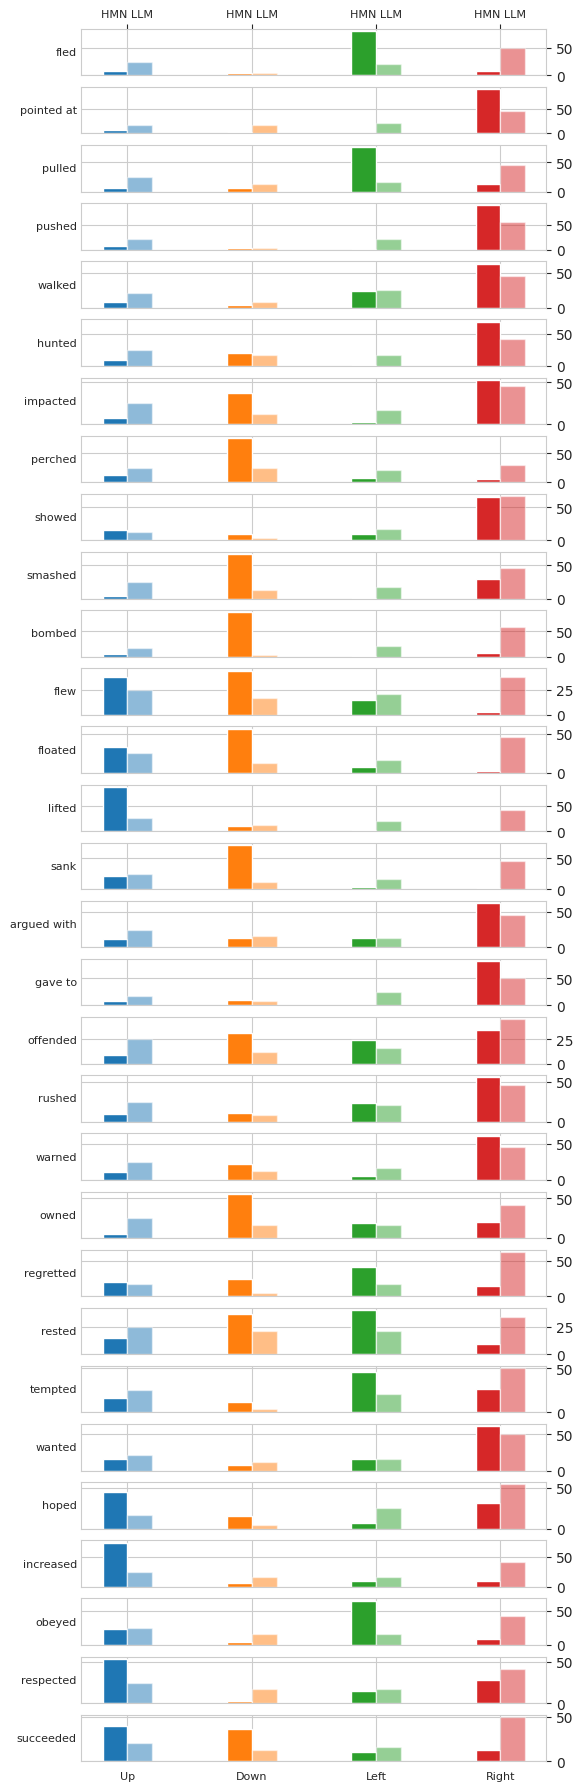

In [78]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Sample data
data_old = richardson_data
data_new = model_percentages

action_names = list(data_old.keys())
num_actions = len(action_names)
num_subplots = len(data_old[action_names[0]])

fig_width = 6
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Create a GridSpec layout
fig = plt.figure(figsize=(fig_width, .75*num_actions))  # Adjust the height factor as needed
gs = gridspec.GridSpec(num_actions, 1, figure=fig, hspace=0.25)  # You can adjust hspace as needed

bar_width_old = 0.2  # Width of the old bars
bar_width_new = bar_width_old /2  # Width of the new bars

for i, action in enumerate(action_names):

    values_old = data_old[action]
    values_new = data_new[action]
    
    positions_old = np.arange(num_subplots) 
    positions_new = positions_old + bar_width_old  # Shift the new bars to the right
    
    bottom_old = np.zeros(num_subplots)
    bottom_new = np.zeros(num_subplots)
    
    ax = fig.add_subplot(gs[i, 0])
    
    for j, (value_old, value_new) in enumerate(zip(values_old, values_new)):
        color_A = colors[j]

        ax.bar(positions_old[j]-.1, value_old, bottom=bottom_old[j], width=bar_width_old, color=color_A)
        new_bar_x = positions_new[j] #+ bar_width_new / 2  # Middle of the new bar
        ax.bar(positions_new[j]-.1, value_new, bottom=bottom_new[j], width=bar_width_new*2, color=color_A, alpha=0.5)
        
        bottom_old[j] += value_old
        bottom_new[j] += value_new
        

    ax.set_xticks(positions_old)
    ax.set_xticklabels([])
    
    if i == num_actions - 1:
        ax.set_xticklabels(["Up", 'Down', 'Left', 'Right'], fontsize=8)  # Adjust fontsize as needed
    if i == 0 :
        ax.set_xticklabels(["HMN LLM", 'HMN LLM', 'HMN LLM', 'HMN LLM'], fontsize=8)  # Adjust fontsize as needed
        ax.xaxis.set_ticks_position('top')
        ax.xaxis.set_label_position('top')
        
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
    ax.text(-.01, 0.5, action, transform=ax.transAxes, rotation=0, va='center', ha='right', fontsize=8)

plt.tight_layout()
plt.savefig("results/VISUAL_"+model_name.split("/")[1]+"_Choices.png")
plt.show()
